In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import h5py
import logging
from os import path
from pandas import HDFStore
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import shutil
import tempfile
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import math

from utils import config, load_residues_dataset, split_train_test

%matplotlib inline

In [2]:
num_coefficients=int(config["coefficients"])
root_path=config["root_path"]
hw_results_path= config["hw_results_path"]
seed=int(config["seed"]) or 42
dr=float(config["dropout"]) or 0.2
lr2=float(config["lr2"]) or 1e-3
num_epochs=int(config["num_epochs"]) or 10000
FEATURES=int(config["features"]) or 4096

#Load data from hdf5 file
rdo_root_path = path.join(root_path,hw_results_path)
# print(rdo_root_path)
dataset=load_residues_dataset(rdo_root_path, num_coefficients)

17
Loading file /data/elekin/data/results/03-HANDWRITTING/archimedean-17.h5


In [3]:
train_dataset, test_dataset = split_train_test(dataset, seed=seed)
for feat, targ in test_dataset.take(3):
    print ('Features: {}, Target: {}'.format(feat, targ))
len(train_dataset), len(test_dataset), test_dataset

Features: [[0.09727392 0.08994826 0.09799393 ... 0.23173197 0.28356063 0.16407351]], Target: [[0]]
Features: [[0.2965023  0.25309542 0.2910553  ... 0.7425698  0.75797373 0.49560773]], Target: [[0]]
Features: [[0.3416033  0.28930897 0.3360038  ... 0.8791181  0.8887903  0.58103865]], Target: [[1]]


(34,
 16,
 <CacheDataset shapes: ((None, 4096), (None, 1)), types: (tf.float32, tf.int8)>)

## FCNN SIMPLE ARCHITECTURE ANALISYS

In [4]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-4,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-2,
  patience=200)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(train_dataset, batch_size=4, use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, callbacks=get_callbacks(name),
                        verbose=0)
    return history

Many models train better if you gradually reduce the learning rate during training. 
Use optimizers.schedules to reduce the learning rate over time:

In [5]:
STEPS_PER_EPOCH = 1
FEATURES = 4096

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  1e-3,
  decay_steps=STEPS_PER_EPOCH*1e3,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

inver_opt=get_optimizer()

In [6]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(24, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [7]:
size_histories = {}

In [9]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
                                              optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                98328     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 98,353
Trainable params: 98,353
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5000,  loss:0.6933,  val_accuracy:0.4375,  val_loss:0.6933,  
....................................................................................................
Epoch: 100, accuracy:0.5000,  loss:0.6932,  val_accuracy:0.4375,  val_loss:0.6932,  
....................................................................................................
Epoch: 200, accuracy:0.5000,  loss:0.6932,  val_accuracy:0.4375,  val_loss:0.6932,  
.

In [78]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

test acc: 1.0


In [55]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [56]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',optimizer=get_optimizer())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 263,793
Trainable params: 263,793
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.3529,  loss:0.9920,  val_accuracy:0.5625,  val_loss:0.6471,  
....................................................................................................
Epoch: 100, accuracy:0.6765,  loss:0.6147,  val_accuracy:0.8750,  val_loss:0.5040,  
....................................................................................................
Epoch: 20

In [57]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

test acc: 0.875


In [58]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(FEATURES,)),  
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [59]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",optimizer=get_optimizer())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 268,553
Trainable params: 268,553
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4412,  loss:0.8273,  val_accuracy:0.5625,  val_loss:0.6303,  
................................

In [60]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))

test acc: 0.875


(0.0, 1.5)

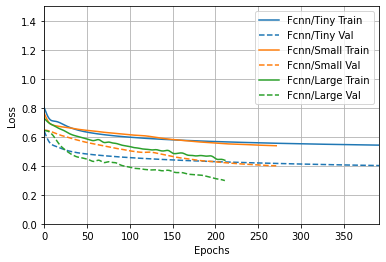

In [61]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 1.5])

(0.0, 1.1)

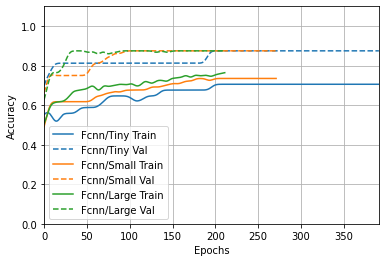

In [37]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0., 1.1])

Text(0.5, 0, 'Epochs [Log Scale]')

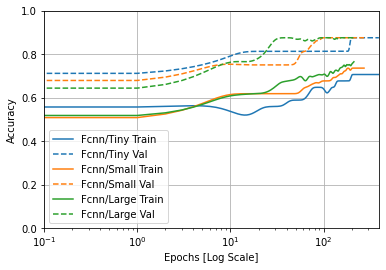

In [38]:
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.ylim([0., 1.])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

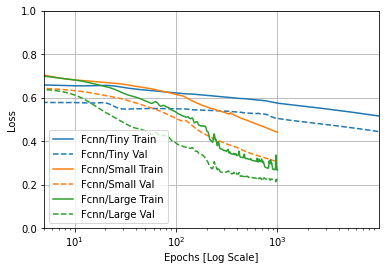

In [22]:
plotter_loss.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.0, 1.])
plt.xlabel("Epochs [Log Scale]")

### Dropout

In [28]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(FEATURES,)),  
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dense(24, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [29]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, "fcnn/tiny/dropout", 
                                                      optimizer=None, 
                                                      max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 268,553
Trainable params: 268,553
Non-trainable params: 0
__________________________________________________

In [1]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

NameError: name 'size_histories' is not defined

(0.0, 1.5)

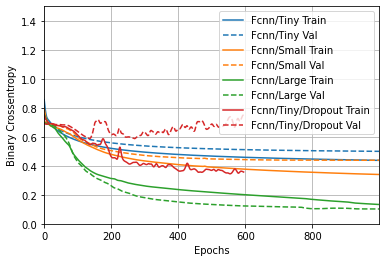

In [31]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 1.5])

(0.0, 1.1)

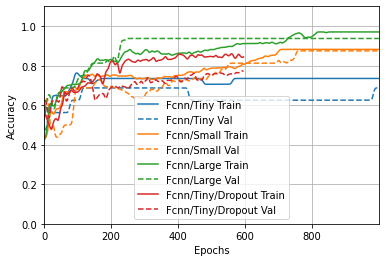

In [32]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0., 1.1])

Since the initial model was not overfitting dropout effect is far away from being something positive for training this network. Let's analyse kernel regularization effect

### Kernel regularizer

In [33]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2),
                 input_shape=(FEATURES,)),
    layers.Dense(64, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [35]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 268,553
Trainable params: 268,553
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.3529,  binary_crossentropy:0.8317,  loss:1.0303,  val_accuracy:0.3750,  val_binary_crossentrop

In [36]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))

test acc: 0.9375


(0.0, 0.9)

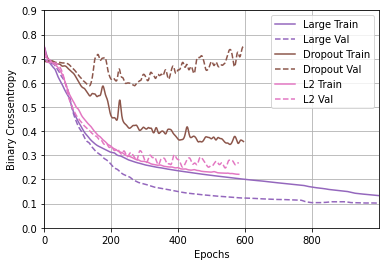

In [37]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 0.9])

(0.1, 1.0)

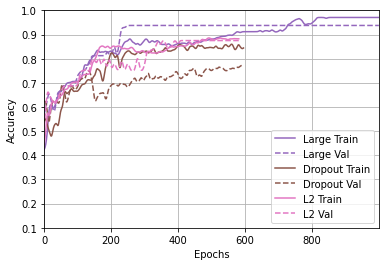

In [38]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.1, 1.])

In [39]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2),
                 input_shape=(FEATURES,)),
    layers.Dense(64, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dropout(dr),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

In [40]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 268,553
Trainable params: 268,553
Non-trainable params: 0
__________________________________________________

In [41]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))

test acc: 0.875


(5.0, 999.0)

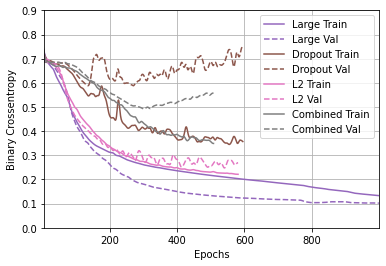

In [42]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 0.9])
plt.xlim([5, max(plt.xlim())])

(0.4, 1.2)

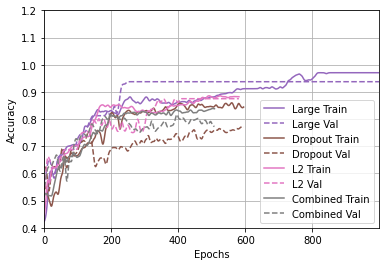

In [43]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.4, 1.2])

## LSTM

In [87]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [200]:
dr=0.2
lr2=1e-8
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[FEATURES,]),
    tf.keras.layers.LSTM(512, activation=tf.nn.tanh, return_sequences=True,
                  kernel_regularizer=regularizers.l2(lr2)),
#     layers.Dropout(dr),
    tf.keras.layers.LSTM(512, activation=tf.nn.tanh,
                 kernel_regularizer=regularizers.l2(lr2)),
#     layers.Dropout(dr),
#     tf.keras.layers.Dense(64, activation=tf.nn.relu),
#                  kernel_regularizer=regularizers.l2(lr2)),  
#     layers.Dropout(dr),
#     tf.keras.layers.Dense(64, activation=tf.nn.relu),
#                  kernel_regularizer=regularizers.l2(lr2)),
#     layers.Dropout(dr),
    tf.keras.layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
#     layers.Dropout(dr),
    tf.keras.layers.Dense(24, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr2)),
    layers.Dropout(dr),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [201]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, "lstm/large")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 4096)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 512)            9439232   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 24)                12312     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))

In [ ]:
plotter_loss.plot(lstm_histories, "loss")
plt.ylim([0., 0.9])
plt.xlim([5, max(plt.xlim())])

In [ ]:
plotter_acc.plot(lstm_histories)
plt.ylim([0., 1.])
plt.xlim([5, max(plt.xlim())])